# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

In [3]:
import pandas as pd
import numpy as np
import math
import json
%matplotlib inline

# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

In [7]:
portfolio

,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5
5,"[web, email, mobile, social]",7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,3
6,"[web, email, mobile, social]",10,10,fafdcd668e3743c1bb461111dcafc2a4,discount,2
7,"[email, mobile, social]",0,3,5a8bc65990b245e5a138643cd4eb9837,informational,0
8,"[web, email, mobile, social]",5,5,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5
9,"[web, email, mobile]",10,7,2906b810c7d4411798c6938adc9daaa5,discount,2


In [5]:
portfolio.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10 entries, 0 to 9
Data columns (total 6 columns):
channels      10 non-null object
difficulty    10 non-null int64
duration      10 non-null int64
id            10 non-null object
offer_type    10 non-null object
reward        10 non-null int64
dtypes: int64(3), object(3)
memory usage: 560.0+ bytes


In [6]:
portfolio.offer_type.value_counts()

bogo             4
discount         4
informational    2
Name: offer_type, dtype: int64

In [10]:
portfolio.describe()

,difficulty,duration,reward
count,10.000000,10.000000,10.000000
mean,7.700000,6.500000,4.200000
std,5.831905,2.321398,3.583915
min,0.000000,3.000000,0.000000
25%,5.000000,5.000000,2.000000
50%,8.500000,7.000000,4.000000
75%,10.000000,7.000000,5.000000
max,20.000000,10.000000,10.000000


In [11]:
profile.head()

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN


In [12]:
profile.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17000 entries, 0 to 16999
Data columns (total 5 columns):
age                 17000 non-null int64
became_member_on    17000 non-null int64
gender              14825 non-null object
id                  17000 non-null object
income              14825 non-null float64
dtypes: float64(1), int64(2), object(2)
memory usage: 796.9+ KB


In [13]:
profile.describe()

,age,became_member_on,income
count,17000.000000,1.700000e+04,14825.000000
mean,62.531412,2.016703e+07,65404.991568
std,26.738580,1.167750e+04,21598.299410
min,18.000000,2.013073e+07,30000.000000
25%,45.000000,2.016053e+07,49000.000000
50%,58.000000,2.017080e+07,64000.000000
75%,73.000000,2.017123e+07,80000.000000
max,118.000000,2.018073e+07,120000.000000


In [14]:
# get missing values in each column dataframe 
profile.isna().sum()

age                    0
became_member_on       0
gender              2175
id                     0
income              2175
dtype: int64

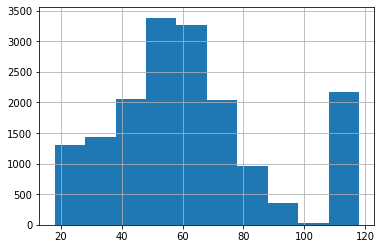

In [15]:
profile.age.hist()

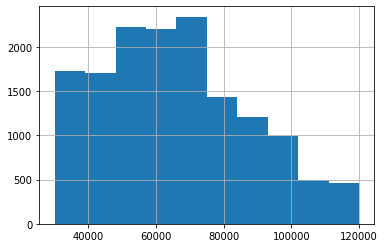

In [16]:
profile.income.hist()

In [22]:
transcript.head(10)

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}
5,offer received,389bc3fa690240e798340f5a15918d5c,0,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'}
6,offer received,c4863c7985cf408faee930f111475da3,0,{'offer id': '2298d6c36e964ae4a3e7e9706d1fb8c2'}
7,offer received,2eeac8d8feae4a8cad5a6af0499a211d,0,{'offer id': '3f207df678b143eea3cee63160fa8bed'}
8,offer received,aa4862eba776480b8bb9c68455b8c2e1,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
9,offer received,31dda685af34476cad5bc968bdb01c53,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}


In [24]:
transcript[transcript.event=='offer completed']

,event,person,time,value
12658,offer completed,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,0,{'offer_id': '2906b810c7d4411798c6938adc9daaa5...
12672,offer completed,fe97aa22dd3e48c8b143116a8403dd52,0,{'offer_id': 'fafdcd668e3743c1bb461111dcafc2a4...
12679,offer completed,629fc02d56414d91bca360decdfa9288,0,{'offer_id': '9b98b8c7a33c4b65b9aebfe6a799e6d9...
12692,offer completed,676506bad68e4161b9bbaffeb039626b,0,{'offer_id': 'ae264e3637204a6fb9bb56bc8210ddfd...
12697,offer completed,8f7dd3b2afe14c078eb4f6e6fe4ba97d,0,{'offer_id': '4d5c57ea9a6940dd891ad53e9dbe8da0...
12717,offer completed,227f2d69e46a4899b70d48182822cff6,0,{'offer_id': '4d5c57ea9a6940dd891ad53e9dbe8da0...
12721,offer completed,bb0f25e23a4c4de6a645527c275cd594,0,{'offer_id': '2298d6c36e964ae4a3e7e9706d1fb8c2...
12744,offer completed,d72d201be5794279aa716d8ad82b8d90,0,{'offer_id': 'f19421c1d4aa40978ebb69ca19b0e20d...
12764,offer completed,73ffefd41e9a4ca3ab26b2b3697c6eb7,0,{'offer_id': '2906b810c7d4411798c6938adc9daaa5...
12767,offer completed,3e621194f72e40d7a0b695ee9b7c38b7,0,{'offer_id': '4d5c57ea9a6940dd891ad53e9dbe8da0...


In [19]:
transcript.event.value_counts()

transaction        138953
offer received      76277
offer viewed        57725
offer completed     33579
Name: event, dtype: int64

In [20]:
transcript.tail(10)

,event,person,time,value
306524,transaction,d613ca9c59dd42f497bdbf6178da54a7,714,{'amount': 25.14}
306525,transaction,eec70ab28af74a22a4aeb889c0317944,714,{'amount': 43.58}
306526,transaction,24f56b5e1849462093931b164eb803b5,714,{'amount': 22.64}
306527,offer completed,24f56b5e1849462093931b164eb803b5,714,{'offer_id': 'fafdcd668e3743c1bb461111dcafc2a4...
306528,transaction,5ca2620962114246ab218fc648eb3934,714,{'amount': 2.2}
306529,transaction,b3a1272bc9904337b331bf348c3e8c17,714,{'amount': 1.5899999999999999}
306530,transaction,68213b08d99a4ae1b0dcb72aebd9aa35,714,{'amount': 9.53}
306531,transaction,a00058cf10334a308c68e7631c529907,714,{'amount': 3.61}
306532,transaction,76ddbd6576844afe811f1a3c0fbb5bec,714,{'amount': 3.5300000000000002}
306533,transaction,c02b10e8752c4d8e9b73f918558531f7,714,{'amount': 4.05}


In [25]:
transcript[transcript.event=='offer viewed']

,event,person,time,value
12650,offer viewed,389bc3fa690240e798340f5a15918d5c,0,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'}
12651,offer viewed,d1ede868e29245ea91818a903fec04c6,0,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'}
12652,offer viewed,102e9454054946fda62242d2e176fdce,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}
12653,offer viewed,02c083884c7d45b39cc68e1314fec56c,0,{'offer id': 'ae264e3637204a6fb9bb56bc8210ddfd'}
12655,offer viewed,be8a5d1981a2458d90b255ddc7e0d174,0,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'}
12656,offer viewed,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
12660,offer viewed,8c7df0c393db488aac3e58b06a7ea5f9,0,{'offer id': '2298d6c36e964ae4a3e7e9706d1fb8c2'}
12661,offer viewed,e528ceb341964128aaf58a59733ec2af,0,{'offer id': '2298d6c36e964ae4a3e7e9706d1fb8c2'}
12662,offer viewed,262ad0fb526a4d53b572007da60cce24,0,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'}
12663,offer viewed,53bac762af27471eb294ff89ca1bae2c,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}


In [32]:
transcript.tail().value.apply(pd.Series)

,amount
306529,1.59
306530,9.53
306531,3.61
306532,3.53
306533,4.05


In [34]:
# Un wrap the dictionary into 2 columns for offer id and amount 
transcript['value'].apply(lambda x: x.get('offer id', np.nan))

0         9b98b8c7a33c4b65b9aebfe6a799e6d9
1         0b1e1539f2cc45b7b9fa7c272da2e1d7
2         2906b810c7d4411798c6938adc9daaa5
3         fafdcd668e3743c1bb461111dcafc2a4
4         4d5c57ea9a6940dd891ad53e9dbe8da0
5         f19421c1d4aa40978ebb69ca19b0e20d
6         2298d6c36e964ae4a3e7e9706d1fb8c2
7         3f207df678b143eea3cee63160fa8bed
8         0b1e1539f2cc45b7b9fa7c272da2e1d7
9         0b1e1539f2cc45b7b9fa7c272da2e1d7
10        0b1e1539f2cc45b7b9fa7c272da2e1d7
11        0b1e1539f2cc45b7b9fa7c272da2e1d7
12        ae264e3637204a6fb9bb56bc8210ddfd
13        3f207df678b143eea3cee63160fa8bed
14        0b1e1539f2cc45b7b9fa7c272da2e1d7
15        fafdcd668e3743c1bb461111dcafc2a4
16        0b1e1539f2cc45b7b9fa7c272da2e1d7
17        2906b810c7d4411798c6938adc9daaa5
18        9b98b8c7a33c4b65b9aebfe6a799e6d9
19        ae264e3637204a6fb9bb56bc8210ddfd
20        2906b810c7d4411798c6938adc9daaa5
21        9b98b8c7a33c4b65b9aebfe6a799e6d9
22        4d5c57ea9a6940dd891ad53e9dbe8da0
23        2

In [35]:
transcript['value'].apply(lambda x: x.get('amount', np.nan))

0           NaN
1           NaN
2           NaN
3           NaN
4           NaN
5           NaN
6           NaN
7           NaN
8           NaN
9           NaN
10          NaN
11          NaN
12          NaN
13          NaN
14          NaN
15          NaN
16          NaN
17          NaN
18          NaN
19          NaN
20          NaN
21          NaN
22          NaN
23          NaN
24          NaN
25          NaN
26          NaN
27          NaN
28          NaN
29          NaN
          ...  
306504     4.89
306505     4.48
306506      NaN
306507      NaN
306508     1.19
306509      NaN
306510    14.31
306511     2.37
306512     6.92
306513    12.73
306514     8.20
306515     2.60
306516     9.20
306517    11.70
306518    40.67
306519    31.13
306520     1.64
306521    17.35
306522     4.42
306523    18.35
306524    25.14
306525    43.58
306526    22.64
306527      NaN
306528     2.20
306529     1.59
306530     9.53
306531     3.61
306532     3.53
306533     4.05
Name: value, Length: 306

In [37]:
transactions_df = transcript[transcript.event == 'transaction']
transactions_df.head()

,event,person,time,value
12654,transaction,02c083884c7d45b39cc68e1314fec56c,0,{'amount': 0.8300000000000001}
12657,transaction,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,0,{'amount': 34.56}
12659,transaction,54890f68699049c2a04d415abc25e717,0,{'amount': 13.23}
12670,transaction,b2f1cd155b864803ad8334cdf13c4bd2,0,{'amount': 19.51}
12671,transaction,fe97aa22dd3e48c8b143116a8403dd52,0,{'amount': 18.97}


In [47]:
# get the amount from the value

transactions_df['amount'] = transactions_df['value'].apply(lambda x: x.get('amount', np.nan))
transactions_df.head()

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,event,person,time,value,amount
12654,transaction,02c083884c7d45b39cc68e1314fec56c,0,{'amount': 0.8300000000000001},0.83
12657,transaction,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,0,{'amount': 34.56},34.56
12659,transaction,54890f68699049c2a04d415abc25e717,0,{'amount': 13.23},13.23
12670,transaction,b2f1cd155b864803ad8334cdf13c4bd2,0,{'amount': 19.51},19.51
12671,transaction,fe97aa22dd3e48c8b143116a8403dd52,0,{'amount': 18.97},18.97


In [48]:
tx_user = pd.DataFrame(profile['id'].unique())
tx_user.columns = ['CustomerID']

#get the last transaction 
max_purchase = transactions_df.groupby('person').time.max().reset_index()
max_purchase.columns = ['CustomerID','MaxPurchaseDate']

#we take our observation point as the max invoice date in our dataset
max_purchase['Recency'] = (max_purchase['MaxPurchaseDate'].max() - max_purchase['MaxPurchaseDate'])

tx_user = pd.merge(tx_user, max_purchase[['CustomerID','Recency']], on='CustomerID')

tx_user.head()

,CustomerID,Recency
0,68be06ca386d4c31939f3a4f0e3dd783,18
1,0610b486422d4921ae7d2bf64640c50b,186
2,38fe809add3b4fcf9315a9694bb96ff5,18
3,78afa995795e4d85b5d9ceeca43f5fef,180
4,a03223e636434f42ac4c3df47e8bac43,102


In [49]:
tx_user.Recency.describe()

count    16578.000000
mean        85.425262
std         82.766010
min          0.000000
25%         24.000000
50%         60.000000
75%        120.000000
max        702.000000
Name: Recency, dtype: float64

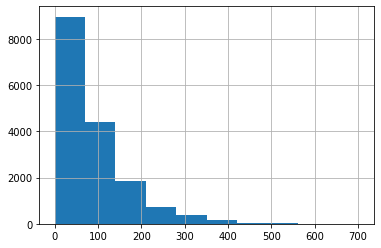

In [50]:
tx_user.Recency.hist()

In [51]:
# then this can be clustered and given different numbers
#frequecy 
tx_frequency = transactions_df.groupby('person').time.count().reset_index()
tx_frequency.columns = ['CustomerID', 'Frequency']

tx_user = pd.merge(tx_user, tx_frequency, on='CustomerID')
tx_user.head()

,CustomerID,Recency,Frequency
0,68be06ca386d4c31939f3a4f0e3dd783,18,9
1,0610b486422d4921ae7d2bf64640c50b,186,3
2,38fe809add3b4fcf9315a9694bb96ff5,18,6
3,78afa995795e4d85b5d9ceeca43f5fef,180,7
4,a03223e636434f42ac4c3df47e8bac43,102,3


In [53]:
# revenue sum up the amount we don't have a unit price --> sum the amount
tx_revenue = transactions_df.groupby('person').amount.sum().reset_index()
tx_revenue.columns = ['CustomerID', 'Revenue']
tx_user = pd.merge(tx_user, tx_revenue, on='CustomerID')
tx_user.head()


,CustomerID,Recency,Frequency,Revenue
0,68be06ca386d4c31939f3a4f0e3dd783,18,9,20.40
1,0610b486422d4921ae7d2bf64640c50b,186,3,77.01
2,38fe809add3b4fcf9315a9694bb96ff5,18,6,14.30
3,78afa995795e4d85b5d9ceeca43f5fef,180,7,159.27
4,a03223e636434f42ac4c3df47e8bac43,102,3,4.65


In [54]:
# offers related 
transcript.event.value_counts()

transaction        138953
offer received      76277
offer viewed        57725
offer completed     33579
Name: event, dtype: int64

In [57]:
offers_df = transcript[transcript.event != 'transaction']
offers_df.head()

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}


In [63]:
offers_df['offer_id'] = offers_df['value'].apply(lambda x: x.get('offer id', np.nan))
offers_df.head()

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


,event,person,time,value,offer_id
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},9b98b8c7a33c4b65b9aebfe6a799e6d9
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0b1e1539f2cc45b7b9fa7c272da2e1d7
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},2906b810c7d4411798c6938adc9daaa5
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},fafdcd668e3743c1bb461111dcafc2a4
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},4d5c57ea9a6940dd891ad53e9dbe8da0


In [65]:
offers_df.event.value_counts()

offer received     76277
offer viewed       57725
offer completed    33579
Name: event, dtype: int64

In [68]:
portfolio.rename(columns={'id':'offer_id'},inplace=True)

In [69]:
#merge_offers = 
offers_df.merge(portfolio,on='offer_id', how='left')

,event,person,time,value,offer_id,channels,difficulty,duration,offer_type,reward
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},9b98b8c7a33c4b65b9aebfe6a799e6d9,"[web, email, mobile]",5.0,7.0,bogo,5.0
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0b1e1539f2cc45b7b9fa7c272da2e1d7,"[web, email]",20.0,10.0,discount,5.0
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},2906b810c7d4411798c6938adc9daaa5,"[web, email, mobile]",10.0,7.0,discount,2.0
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},fafdcd668e3743c1bb461111dcafc2a4,"[web, email, mobile, social]",10.0,10.0,discount,2.0
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},4d5c57ea9a6940dd891ad53e9dbe8da0,"[web, email, mobile, social]",10.0,5.0,bogo,10.0
5,offer received,389bc3fa690240e798340f5a15918d5c,0,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'},f19421c1d4aa40978ebb69ca19b0e20d,"[web, email, mobile, social]",5.0,5.0,bogo,5.0
6,offer received,c4863c7985cf408faee930f111475da3,0,{'offer id': '2298d6c36e964ae4a3e7e9706d1fb8c2'},2298d6c36e964ae4a3e7e9706d1fb8c2,"[web, email, mobile, social]",7.0,7.0,discount,3.0
7,offer received,2eeac8d8feae4a8cad5a6af0499a211d,0,{'offer id': '3f207df678b143eea3cee63160fa8bed'},3f207df678b143eea3cee63160fa8bed,"[web, email, mobile]",0.0,4.0,informational,0.0
8,offer received,aa4862eba776480b8bb9c68455b8c2e1,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0b1e1539f2cc45b7b9fa7c272da2e1d7,"[web, email]",20.0,10.0,discount,5.0
9,offer received,31dda685af34476cad5bc968bdb01c53,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0b1e1539f2cc45b7b9fa7c272da2e1d7,"[web, email]",20.0,10.0,discount,5.0


In [66]:
# issue we have multiple offers completed at once 
offers_df.groupby(['person', 'offer_id', 'event'])['time'].apply(lambda x: list(x)).unstack('event').reset_index()

event,person,offer_id,offer received,offer viewed
0,0009655768c64bdeb2e877511632db8f,2906b810c7d4411798c6938adc9daaa5,[576],None
1,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,[336],[372]
2,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,[168],[192]
3,0009655768c64bdeb2e877511632db8f,f19421c1d4aa40978ebb69ca19b0e20d,[408],[456]
4,0009655768c64bdeb2e877511632db8f,fafdcd668e3743c1bb461111dcafc2a4,[504],[540]
5,00116118485d4dfda04fdbaba9a87b5c,f19421c1d4aa40978ebb69ca19b0e20d,"[168, 576]","[216, 630]"
6,0011e0d4e6b944f998e987f904e8c1e5,0b1e1539f2cc45b7b9fa7c272da2e1d7,[408],[432]
7,0011e0d4e6b944f998e987f904e8c1e5,2298d6c36e964ae4a3e7e9706d1fb8c2,[168],[186]
8,0011e0d4e6b944f998e987f904e8c1e5,3f207df678b143eea3cee63160fa8bed,[0],[6]
9,0011e0d4e6b944f998e987f904e8c1e5,5a8bc65990b245e5a138643cd4eb9837,[336],[354]
